<a href="https://colab.research.google.com/github/KrutikaBhavsar/machine-learning-/blob/main/assignment01/NLP_hw01_texts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment 01

In this task, we will consider the task of classifying texts. To achieve the best results, we will use informative feature descriptions for words.

In [ ]:
# do not change the code in the block below
# __________start of block__________
from collections import Counter

import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator
from sklearn.linear_model import LogisticRegression
from sklearn import naive_bayes
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

import torch
from torch import nn
from torch.nn import functional as F
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau



from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline


out_dict = dict()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# __________end of block__________

### Text preprocessing and tokenization

The preprocessing is almost similar to the one discussed at the lecture. `nltk` library [link](https://www.nltk.org ) is widely used in text processing. At the link above, you can find its detailed description and documentation.

In [ ]:
# do not change the code in the block below
# __________start of block__________
df = pd.read_csv(
    'https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv',
    delimiter='\t',
    header=None
)

texts_train = df[0].values[:5000]
y_train = df[1].values[:5000]
texts_test = df[0].values[5000:]
y_test = df[1].values[5000:]

from nltk.tokenize import WordPunctTokenizer
tokenizer = WordPunctTokenizer()
preprocess = lambda text: ' '.join(tokenizer.tokenize(text.lower()))

text = 'How to be a grown-up at work: replace "I don\'t want to do that" with "Ok, great!".'
print("before:", text,)
print("after:", preprocess(text),)

texts_train = [preprocess(text) for text in texts_train]
texts_test = [preprocess(text) for text in texts_test]

# Small check that everything is done properly
assert texts_train[5] ==  'campanella gets the tone just right funny in the middle of sad in the middle of hopeful'
assert texts_test[74] == 'poetry in motion captured on film'
assert len(texts_test) == len(y_test)
# __________end of block__________

before: How to be a grown-up at work: replace "I don't want to do that" with "Ok, great!".
after: how to be a grown - up at work : replace " i don ' t want to do that " with " ok , great !".


The following functions will help you with visualizing the network learning process.

In [ ]:
# do not change the code in the block below
# __________start of block__________
def plot_train_process(train_loss, val_loss, train_accuracy, val_accuracy, title_suffix=''):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title(' '.join(['Loss', title_suffix]))
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title(' '.join(['Validation accuracy', title_suffix]))
    axes[1].plot(train_accuracy, label='train')
    axes[1].plot(val_accuracy, label='validation')
    axes[1].legend()
    plt.show()

def visualize_and_save_results(model, model_name, X_train, X_test, y_train, y_test, out_dict):
    for data_name, X, y, model in [
    ('train', X_train, y_train, model),
    ('test', X_test, y_test, model)
    ]:
        if isinstance(model, BaseEstimator):
            proba = model.predict_proba(X)[:, 1]
        elif isinstance(model, nn.Module):
            proba = model(X).detach().cpu().numpy()[:, 1]
        else:
            raise ValueError('Unrecognized model type')
            
        auc = roc_auc_score(y, proba)

        out_dict['{}_{}'.format(model_name, data_name)] = auc
        plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (data_name, auc))

    plt.plot([0, 1], [0, 1], '--', color='black',)
    plt.legend(fontsize='large')
    plt.title(model_name)
    plt.grid()
    return out_dict
# __________end of block__________

### Task №1. A bag of words.

Use the classic approach to text vectorization: a bag of words. To do this, you can either use the `CountVectorizer` from `sklearn`, or implement it yourself. Please note that in this task only `k` of the most frequently encountered words from the training part of the sample are used

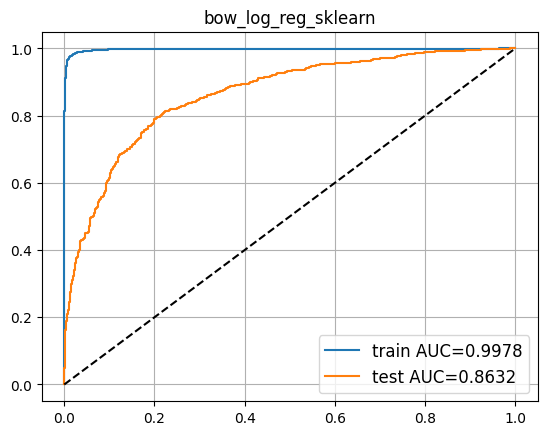

In [ ]:
# do not change the code in the block below
# __________start of block__________

k = min(10000, len(set(' '.join(texts_train).split())))

counts = Counter(' '.join(texts_train).split())

bow_vocabulary = [key for key, val in counts.most_common(k)]


def text_to_bow(text):
    """ convert text string to an array of token counts. Use bow_vocabulary. """
    sent_vec = np.zeros(len(bow_vocabulary))
    counts = Counter(text.split())
    for i, token in enumerate(bow_vocabulary):
        if token in counts:
            sent_vec[i] = counts[token]
    return np.array(sent_vec, 'float32')

X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
X_test_bow = np.stack(list(map(text_to_bow, texts_test)))

# Small check that everything is done properly if you are using local bow implementation
k_max = len(set(' '.join(texts_train).split()))
assert X_train_bow.shape == (len(texts_train), min(k, k_max))
assert X_test_bow.shape == (len(texts_test), min(k, k_max))
assert np.all(X_train_bow[5:10].sum(-1) == np.array([len(s.split()) for s in  texts_train[5:10]]))
assert len(bow_vocabulary) <= min(k, k_max)
assert X_train_bow[65, bow_vocabulary.index('!')] == texts_train[65].split().count('!')


bow_model = LogisticRegression(max_iter=1500).fit(X_train_bow, y_train)

out_dict = visualize_and_save_results(bow_model, 'bow_log_reg_sklearn', X_train_bow, X_test_bow, y_train, y_test, out_dict)
# __________end of block__________

The results are not bad, but retraining is clearly visible. This conclusion can be made judging by the significant quality superiority (AUC ROC) on the train sample relative to test. Moreover, on the training sample, the quality tends to unity, while on the deferred sample it is much lower, i.e. the model has caught a lot of dependencies peculiar only to the training sample. The basic problem of retraining was considered in [lecture No. 3](https://youtu.be/Ql00acFsEhE).She will meet in more detail more than once during the further course.

In this task, we will deal with retraining in the future. Now implement a solution based on logistic regression, but already using Pwtorch. As a result, you should have access to a trained model that predicts probabilities for two classes. The quality of the test sample should not be inferior to the logistic regression.

In [ ]:
import torch
import torch.nn as nn

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 2)

    def forward(self, x):
        return self.linear(x)

input_dim = X_train_bow.shape[1]
model = LogisticRegressionModel(input_dim)
loss_function = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

X_train_bow_torch = torch.tensor(X_train_bow, dtype=torch.float32)
X_test_bow_torch = torch.tensor(X_test_bow, dtype=torch.float32)

y_train_torch = torch.tensor(y_train, dtype=torch.long)
y_test_torch = torch.tensor(y_test, dtype=torch.long)

Don't forget about the loss functions: `nn.CrossEntropyLoss` combines `LogSoftMax` and `NLLLoss'. Also, do not forget about the need to transfer tensors to the used `device'.

The function below will help with training the model. Some of the code must be implemented independently.

In [ ]:
def train_model(
    model,
    opt,
    X_train_torch,
    y_train_torch,
    X_val_torch,
    y_val_torch,
    n_iterations=500,
    batch_size=32,
    show_plots=True,
    eval_every=50
):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    local_train_loss_history = []
    local_train_acc_history = []
    for i in range(n_iterations):

        # sample batch_size random observations
        ix = np.random.randint(0, len(X_train_torch), batch_size)
        x_batch = X_train_torch[ix]
        y_batch = y_train_torch[ix]

        # predict log-probabilities or logits
        y_predicted = model(x_batch)
        
        # compute loss, just like before
        loss = loss_function(y_predicted, y_batch)

        # compute gradients
        loss.backward()

        # Adam step
        opt.step()

        # clear gradients
        opt.zero_grad()

        local_train_loss_history.append(loss.item())
        local_train_acc_history.append(
            accuracy_score(
                y_batch.to('cpu').detach().numpy(),
                y_predicted.to('cpu').detach().numpy().argmax(axis=1)
            )
        )

        if i % eval_every == 0:
            train_loss_history.append(np.mean(local_train_loss_history))
            train_acc_history.append(np.mean(local_train_acc_history))
            local_train_loss_history, local_train_acc_history = [], []

            predictions_val = model(X_val_torch)
            val_loss_history.append(loss_function(predictions_val, y_val_torch).to('cpu').detach().item())

            acc_score_val = accuracy_score(y_val_torch.cpu().numpy(), predictions_val.to('cpu').detach().numpy().argmax(axis=1))
            val_acc_history.append(acc_score_val)

            if show_plots:
                display.clear_output(wait=True)
                plot_train_process(train_loss_history, val_loss_history, train_acc_history, val_acc_history)
    return model

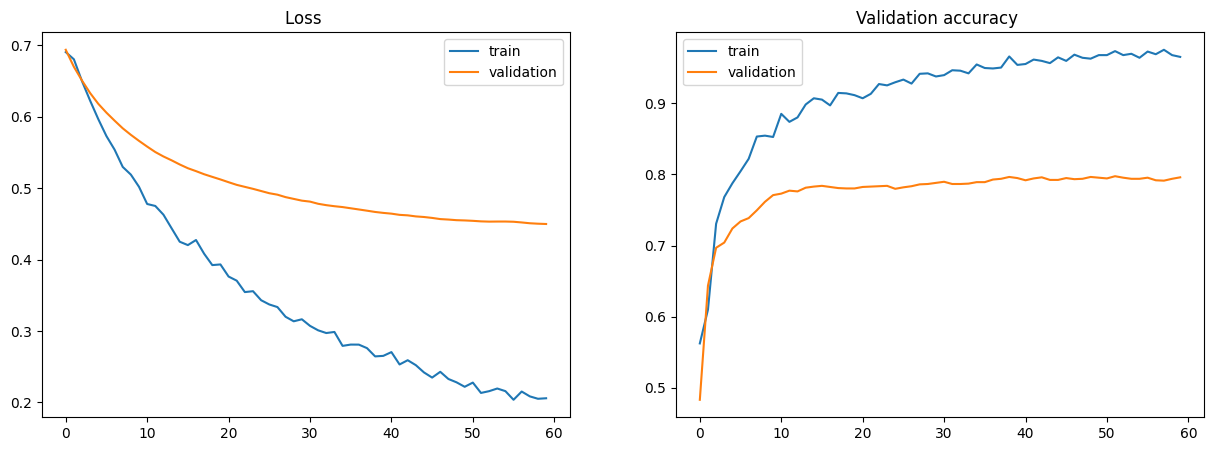

In [ ]:
bow_nn_model = train_model(model, opt, X_train_bow_torch, y_train_torch, X_test_bow_torch, y_test_torch, n_iterations=3000)

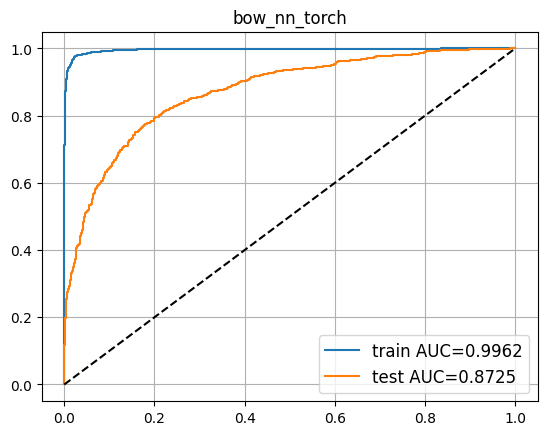

In [ ]:
# do not change the code in the block below
# __________start of block__________
out_dict = visualize_and_save_results(bow_nn_model, 'bow_nn_torch', X_train_bow_torch, X_test_bow_torch, y_train, y_test, out_dict)

assert out_dict['bow_log_reg_sklearn_test'] - out_dict['bow_nn_torch_test'] < 0.01, 'AUC ROC on test data should be close to the sklearn implementation'
# __________end of block__________

And now repeat the training procedure above, but for different values of `k' – the size of the dictionary. In the results list, save the `AUC ROC` on the test part of the sample for a model trained with a dictionary of size `k'.

In [ ]:
vocab_sizes_list = np.arange(100, 5800, 700)
results = []
from collections import Counter

def most_common_words(k):
    counter = Counter()
    for text in texts_train:
        counter.update(text.split())
    return [word for word, _ in counter.most_common(k)]
def text_to_bow_vocabulary(text, vocabulary):
    """
    Converts a given text to a bag-of-words representation based on the provided vocabulary.
    """
    result = np.zeros(len(vocabulary))
    for word in text.split():
        if word in vocabulary:
            result[vocabulary.index(word)] += 1
    return result

for k in vocab_sizes_list:
    bow_vocabulary_k = most_common_words(k)
    
    X_train_bow_k = np.stack([text_to_bow_vocabulary(text, bow_vocabulary_k) for text in texts_train])
    X_test_bow_k = np.stack([text_to_bow_vocabulary(text, bow_vocabulary_k) for text in texts_test])
    
    X_train_bow_torch_k = torch.tensor(X_train_bow_k, dtype=torch.float32)
    X_test_bow_torch_k = torch.tensor(X_test_bow_k, dtype=torch.float32)

    model_k = LogisticRegressionModel(X_train_bow_k.shape[1])
    opt_k = torch.optim.Adam(model_k.parameters(), lr=1e-3)
    
    bow_nn_model_k = train_model(model_k, opt_k, X_train_bow_torch_k, y_train_torch, X_test_bow_torch_k, y_test_torch, n_iterations=3000, show_plots=False)
    
    with torch.no_grad():
        predicted_probas_on_test_for_k_sized_dict = bow_nn_model_k(X_test_bow_torch_k)[:, 1].cpu().numpy()

    assert predicted_probas_on_test_for_k_sized_dict is not None
    auc = roc_auc_score(y_test, predicted_probas_on_test_for_k_sized_dict)
    results.append(auc)

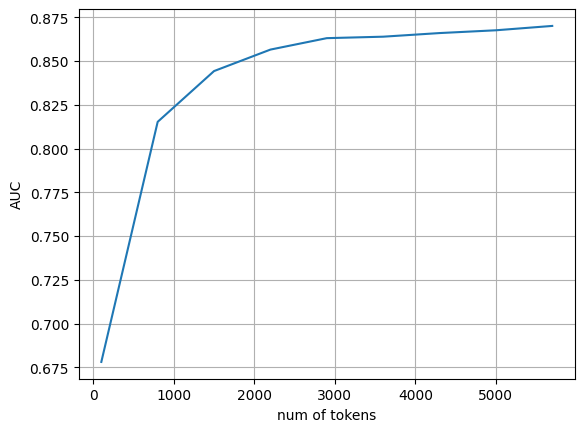

In [ ]:
# do not change the code in the block below
# __________start of block__________
assert len(results) == len(vocab_sizes_list), 'Check the code above'
assert min(results) >= 0.65, 'Seems like the model is not trained well enough'
assert results[-1] > 0.84, 'Best AUC ROC should not be lower than 0.84'

plt.plot(vocab_sizes_list, results)
plt.xlabel('num of tokens')
plt.ylabel('AUC')
plt.grid()

out_dict['bow_k_vary'] = results
# __________end of block__________

### Task #2: Using TF-iDF features.

You can also use TF-iDF to vectorize texts. This makes it possible to exclude from consideration many words that do not have a significant impact when assessing the dissimilarity of texts.

You can read more about TF-iDF, for example, [здесь](https://towardsdatascience.com/tf-idf-form-document-ranking-from-scratch-in-python-on-real-world-dataset-796d339a4089) .
There you can also read about its independent implementation.

Your task: vectorize texts using TF-iDF (or `TfidfVectorizer` from `sklearn`, or by implementing it yourself) and build a classifier using PyTorch, similar to task #1.

Then also evaluate the quality of the AUC ROC classification for different dictionary sizes.

The classification quality must be at least 0.86 AUC ROC.

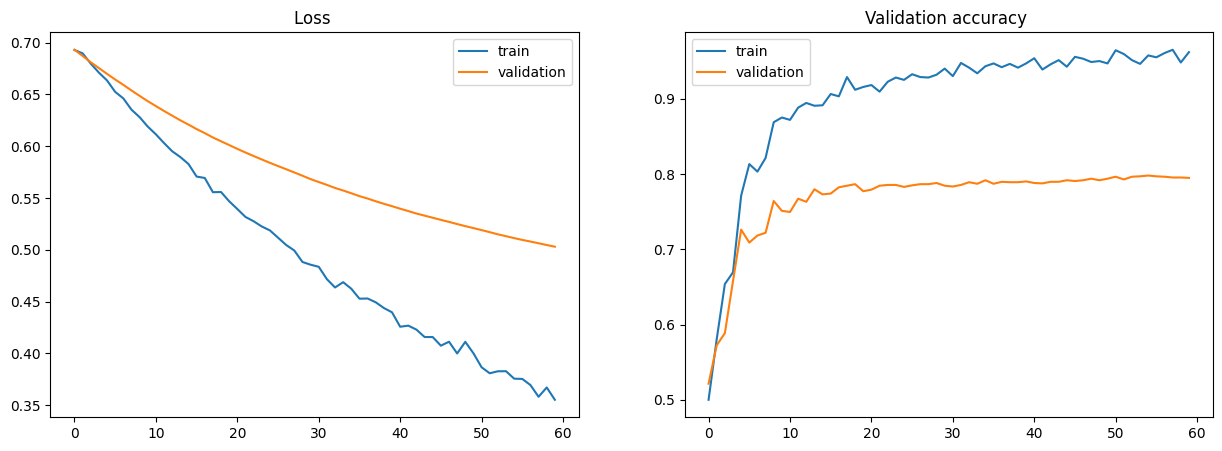

In [ ]:
import numpy as np
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score

# Define the model
class LogisticRegressionModel(torch.nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = torch.nn.Linear(input_dim, 2)

    def forward(self, x):
        return self.linear(x)

# Vectorize texts using TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(texts_train).toarray()
X_test_tfidf = vectorizer.transform(texts_test).toarray()

# Convert data to PyTorch tensors
X_train_tfidf_torch = torch.tensor(X_train_tfidf, dtype=torch.float32)
X_test_tfidf_torch = torch.tensor(X_test_tfidf, dtype=torch.float32)

# Build the model
model = LogisticRegressionModel(X_train_tfidf.shape[1])

# Set the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train the model
model_tf_idf = train_model(model, opt, X_train_tfidf_torch, y_train_torch, X_test_tfidf_torch, y_test_torch, n_iterations=3000)

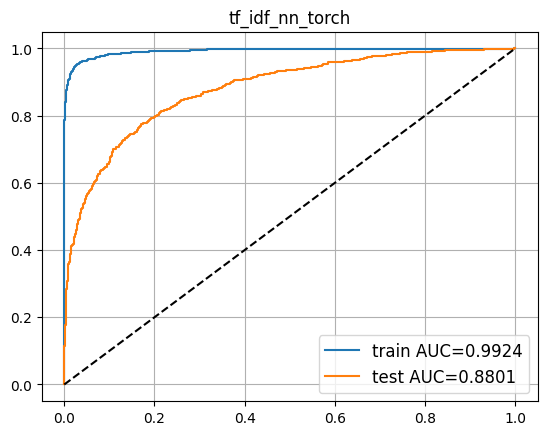

In [ ]:
# do not change the code in the block below
# __________start of block__________
out_dict = visualize_and_save_results(model_tf_idf, 'tf_idf_nn_torch', X_train_tfidf_torch, X_test_tfidf_torch, y_train, y_test, out_dict)

assert out_dict['tf_idf_nn_torch_test'] >= out_dict['bow_nn_torch_test'], 'AUC ROC on test data should be better or close to BoW for TF-iDF features'
# __________end of block__________

Similarly to task #1, repeat the training procedure for different values of the `k`– size of the dictionary and save the `AUC ROC` on the test part of the sample to the `results` list.

In [ ]:
vocab_sizes_list = np.arange(100, 5800, 700)
results= []

for k in vocab_sizes_list:
    # Vectorize texts using TfidfVectorizer with limited vocabulary size
    vectorizer = TfidfVectorizer(max_features=k)
    X_train_tfidf = vectorizer.fit_transform(texts_train).toarray()
    X_test_tfidf = vectorizer.transform(texts_test).toarray()

    # Convert data to PyTorch tensors
    X_train_tfidf_torch = torch.tensor(X_train_tfidf, dtype=torch.float32)
    X_test_tfidf_torch = torch.tensor(X_test_tfidf, dtype=torch.float32)

    # Build and train the model
    model_tfidf = LogisticRegressionModel(X_train_tfidf.shape[1])
    loss_function = torch.nn.CrossEntropyLoss()
    opt_tfidf = torch.optim.Adam(model_tfidf.parameters(), lr=1e-3)
    bow_nn_model_tfidf = train_model(model_tfidf, opt_tfidf, X_train_tfidf_torch, y_train_torch, X_test_tfidf_torch, y_test_torch, n_iterations=3000, show_plots=False)

    # Evaluate the quality of the AUC ROC classification
    with torch.no_grad():
        predicted_probas_on_test_for_k_sized_dict = bow_nn_model_tfidf(X_test_tfidf_torch)[:, 1].cpu().numpy()
    assert predicted_probas_on_test_for_k_sized_dict is not None
    auc = roc_auc_score(y_test, predicted_probas_on_test_for_k_sized_dict)
    results.append(auc)

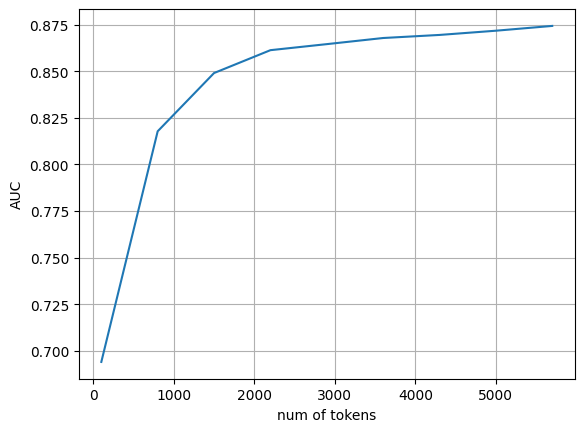

In [ ]:
# do not change the code in the block below
# __________start of block__________
assert len(results) == len(vocab_sizes_list), 'Check the code above'
assert min(results) >= 0.65, 'Seems like the model is not trained well enough'
assert results[-1] > 0.85, 'Best AUC ROC for TF-iDF should not be lower than 0.84'

plt.plot(vocab_sizes_list, results)
plt.xlabel('num of tokens')
plt.ylabel('AUC')
plt.grid()

out_dict['tf_idf_k_vary'] = results
# __________end of block__________

### Task #3: Comparison with a Naive Bayesian classifier.

Classical models are still able to show good results in many tasks. Train a naive Bayesian classifier on texts vectorized using BoW and TF-iDF and compare the results with the models above.

*Comment: we draw your attention, it is necessary to choose an a priori distribution for features suitable for this task, i.e. choose the correct version of the classifier from `sklearn`: `GaussianNB`, `MultinomialNB`, `ComplementNB', `BernoulliNB`, `CategoricalNB`*

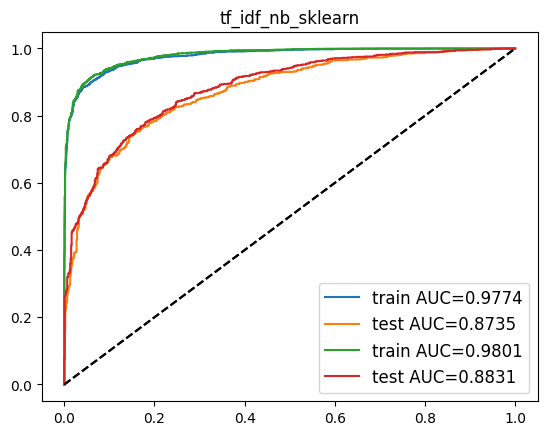

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

# Train a naive Bayesian classifier on texts vectorized using BoW
vectorizer_bow = CountVectorizer(max_features=k)
X_train_bow = vectorizer_bow.fit_transform(texts_train).toarray()
X_test_bow = vectorizer_bow.transform(texts_test).toarray()

clf_nb_bow = MultinomialNB()
clf_nb_bow.fit(X_train_bow, y_train)

# Do not change the code in the block below
out_dict = visualize_and_save_results(clf_nb_bow, 'bow_nb_sklearn', X_train_bow, X_test_bow, y_train, y_test, out_dict)

# Train a naive Bayesian classifier on texts vectorized using TF-iDF
vectorizer_tfidf = TfidfVectorizer(max_features=k)
X_train_tfidf = vectorizer_tfidf.fit_transform(texts_train).toarray()
X_test_tfidf = vectorizer_tfidf.transform(texts_test).toarray()

clf_nb_tfidf = MultinomialNB()
clf_nb_tfidf.fit(X_train_tfidf, y_train)

# Do not change the code in the block below
out_dict = visualize_and_save_results(clf_nb_tfidf, 'tf_idf_nb_sklearn', X_train_tfidf, X_test_tfidf, y_train, y_test, out_dict)

In [ ]:
# do not change the code in the block below
# __________start of block__________
assert out_dict['tf_idf_nb_sklearn_test'] > out_dict['bow_nb_sklearn_test'],' TF-iDF results should be better'
assert out_dict['tf_idf_nb_sklearn_test'] > 0.86, 'TF-iDF Naive Bayes score should be above 0.86'
# __________end of block__________

### Task #4: Using pre-trained embeddings

Finally, let's use the pre-trained embeddings from the 'gensim` library. There are several embeddings available in it, pre-trained on various text corpora. The full list can be found [here](https://radimrehurek.com/gensim/models/word2vec.html#pretrained-models ). We remind you that it is better to use those embeddings that have been trained on texts of a similar structure.

Your task: to train the model (logistic regression or a two-layer neural network is enough) using averaged embedding for all tokens in the recall, to achieve quality no worse than using BoW/TF-iDF and to reduce the degree of retraining (the difference between AUC ROC on training and test samples).

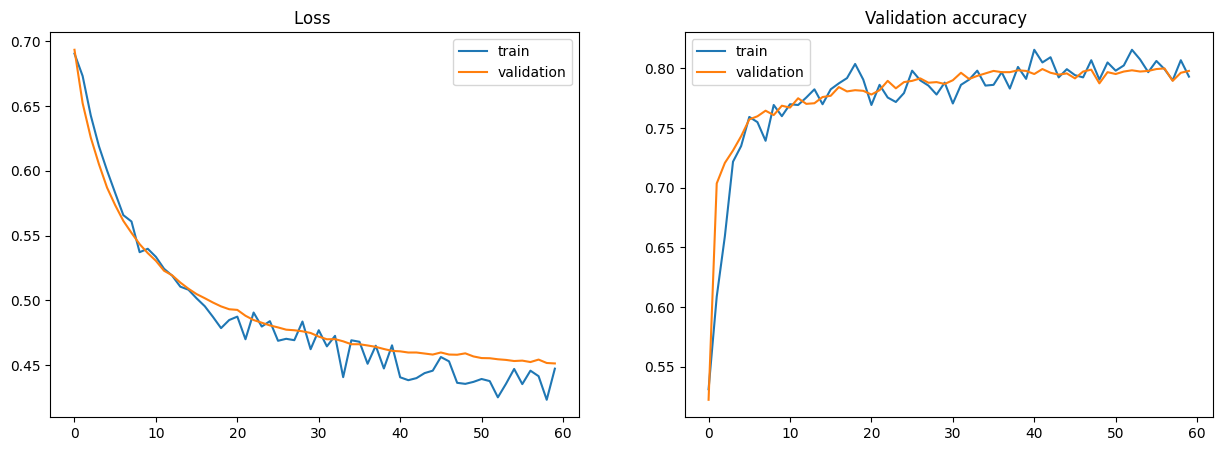

In [ ]:
import gensim.downloader as api

# Load pre-trained embeddings
gensim_embedding_model = api.load('glove-wiki-gigaword-300')

def text_to_average_embedding(text, gensim_embedding_model):
    tokens = text.split()
    embedding_for_text = np.zeros(gensim_embedding_model.vector_size)
    n_tokens = 0

    for token in tokens:
        if token in gensim_embedding_model:
            embedding_for_text += gensim_embedding_model[token]
            n_tokens += 1

    if n_tokens > 0:
        embedding_for_text /= n_tokens

    return embedding_for_text

# Convert texts to average embeddings
X_train_emb = [text_to_average_embedding(text, gensim_embedding_model) for text in texts_train]
X_test_emb = [text_to_average_embedding(text, gensim_embedding_model) for text in texts_test]

assert len(X_train_emb[0]) == gensim_embedding_model.vector_size, 'Seems like the embedding shape is wrong'

# Convert data to PyTorch tensors
X_train_emb_torch = torch.tensor(X_train_emb, dtype=torch.float32)
X_test_emb_torch = torch.tensor(X_test_emb, dtype=torch.float32)

y_train_torch = torch.tensor(y_train, dtype=torch.long)
y_test_torch = torch.tensor(y_test, dtype=torch.long)

# Build and train the model
model = LogisticRegressionModel(gensim_embedding_model.vector_size)
loss_function = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

model = train_model(model, opt, X_train_emb_torch, y_train_torch, X_test_emb_torch, y_test_torch, n_iterations=3000)

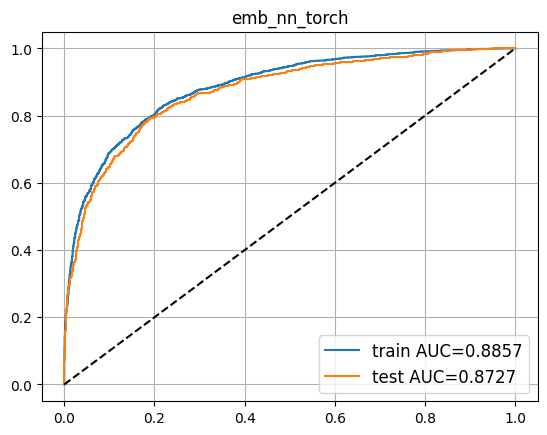

In [ ]:
# do not change the code in the block below
# __________start of block__________

out_dict = visualize_and_save_results(model, 'emb_nn_torch', X_train_emb_torch, X_test_emb_torch, y_train, y_test, out_dict)
assert out_dict['emb_nn_torch_test'] > 0.87, 'AUC ROC on test data should be better than 0.86'
assert out_dict['emb_nn_torch_train'] - out_dict['emb_nn_torch_test'] < 0.1, 'AUC ROC on test and train data should not be different more than by 0.1'
# __________end of block__________

### Assignment submission
Run the code below to generate the parcel and submit the file `submission_dict_101.npy` for verification.

In [ ]:
# do not change the code in the block below
# __________start of block__________

np.save('submission_dict_101.npy', out_dict, allow_pickle=True)
print('File saved to `submission_dict_101.npy`')
# __________end of block__________

File saved to `submission_dict_101.npy`
